<div class="alert alert-success" style="font-size: 16px;">
    <div style="font-size: 22px; font-weight:bold; margin: 10px 0px;">Topic Modeling</div>
After preprocessing we have to vectorize our preprocessed text and train our topic model.
</div>

## Imports


In [75]:
import datetime as dt
import os

import gensim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import spacy
from csaps import csaps
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from tqdm.notebook import tqdm

from util.conferences import correct_cwd
from util.conferences import get_conference_data

try:
    nlp
except:
    nlp = spacy.load("nl_core_news_lg")

In [76]:
correct_cwd()

## Get Data

In [77]:
conferences_data = get_conference_data()

In [78]:
merged_texts = [text_rutte['text'] + text_de_jonge['text'] for text_rutte, text_de_jonge in
                zip(conferences_data[0], conferences_data[1])]
date_strings = [conference['date'] for conference in conferences_data[0]]
dates = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in date_strings]

## Tokenize Texts

In [79]:
try:
    processed_texts
except:
    processed_texts = [text for text in
                       tqdm(nlp.pipe(merged_texts, n_process=1, disable=["ner", "parser"]), total=len(merged_texts))]

In [80]:
# processed_texts[:10]

In [81]:
# word.pos_ == 'VERB' and not 
tokenized_texts_lem = [[word.lemma_ for word in processed_text if not word.is_stop and not word.is_punct] for
                       processed_text in processed_texts]

## Vectorization

In [82]:
MIN_DF = 1  # minium document frequency
MAX_DF = 0.6  # maximum document frequency

dictionary = Dictionary(tokenized_texts_lem)  # get the vocabulary
dictionary.filter_extremes(no_below=MIN_DF,
                           no_above=MAX_DF)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts_lem]
print(len(corpus))

60


## Train Model

In [83]:
os.environ.update({'MALLET_HOME': r'C:/mallet/'})
PATH_TO_MALLET = r'C:/mallet/bin/mallet.bat'

N_TOPICS = 10
N_ITERATIONS = 1000  # usually 1000 will do

lda = LdaMallet(PATH_TO_MALLET,
                corpus=corpus,
                id2word=dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS,
                random_seed=42)

## Show Topics

In [84]:
for topic in range(N_TOPICS):
    words = lda.show_topic(topic, 10)
    topic_n_words = ' '.join([word[0] for word in words])
    print('Topic {}: {}'.format(str(topic), topic_n_words))

Topic 0: vaccineren coronatoegangsbewij vaccinatie keuze verplichten vaccinatiegraad evenement hoog september prik
Topic 1: variant brits maart avondklok vaccineren crisis einde vaccin februari vaccinatie
Topic 2: brabant vrijdag bijzonder crisis nabestaande bruno minister grens ouder schudden
Topic 3: weekend ervoor ding zaak uiteraard nogmaals enorm straat nou spreken
Topic 4: juni vervoer juli openbaar drukken september vermijden controle verspreiding gebruiken
Topic 5: 28 april intensive vol. ic voorzichtig letterlijk care ankerpunt normaal
Topic 6: stap zomer prik vaccineren zaterdag juni   5 woensdag 2
Topic 7: omikronvariant januari   kerst booster halen omikron boosterprik variant vaccineren
Topic 8: regio landelijk lokaal beperken gedeeltelijk voorjaar lockdown regionaal bron- maart
Topic 9: testen onderwijs corona maand hoog school kind uur oud maximaal


## Visualisation with pyLDAvis

In [85]:
transformed_docs = lda.load_document_topics()
topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in transformed_docs],
                                   columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
topic_distributions.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000446,0.000301,0.345383,0.352263,0.000831,0.000540,0.000544,0.000269,0.000537,0.298886
1,0.000227,0.000153,0.485713,0.363436,0.000423,0.000275,0.000277,0.000137,0.000273,0.149087
2,0.002596,0.001752,0.169171,0.008393,0.071776,0.270901,0.003166,0.001563,0.003125,0.467557
3,0.000243,0.000164,0.370218,0.408466,0.009861,0.000295,0.000297,0.000146,0.009701,0.200609
4,0.000188,0.000127,0.501491,0.131397,0.000350,0.000228,0.000229,0.000113,0.000226,0.365652


In [86]:
pyLDAvis.enable_notebook()

lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda)

gensimvis.prepare(lda_conv, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.070550 -0.039982       1        1  46.765400
3      0.207877 -0.040652       2        1   9.489712
6     -0.143281 -0.133651       3        1   8.712511
4      0.050883 -0.168307       4        1   6.882844
0     -0.173593  0.024021       5        1   6.702185
8      0.076743  0.008802       6        1   5.961026
1     -0.174821  0.069176       7        1   4.688035
7     -0.253278  0.088051       8        1   4.329180
5      0.157766 -0.158004       9        1   3.700820
2      0.181153  0.350546      10        1   2.768286, topic_info=              Term        Freq       Total Category  logprob  loglift
3480    vaccineren  160.000000  160.000000  Default  30.0000  30.0000
1031          juni  108.000000  108.000000  Default  29.0000  29.0000
103           stap  156.000000  156.000000  Default  28.0000  28.0000
958          april   61.000000   61.000000  Default  27.0000  27.0000
414           hoog  123.000000  123.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
82    ongelooflijk    5.067272   38.663240  Topic10  -5.0802   1.5549
306        zakdoek    4.053818   13.974381  Topic10  -5.3033   2.3494
178      evenement    4.053818   51.467819  Topic10  -5.3033   1.0456
150        besluit    4.053818   80.489739  Topic10  -5.3033   0.5985
308           ziek    4.053818   67.443638  Topic10  -5.3033   0.7753

[888 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
2475      6  0.999676  0800-1202
4444      5  1.004704        1.8
1288      1  0.490259         10
1288      3  0.420222         10
1288      7  0.070037         10
...     ...       ...        ...
3190      5  1.004704          á
872       1  0.927841        één
872       2  0.067479        één
873       2  0.873264  überhaupt
873       6  0.124752  überhaupt

[1458 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 4, 7, 5, 1, 9, 2, 8, 6, 3])

In [87]:
joined_topic_dist = topic_distributions.copy()
joined_topic_dist['date'] = dates
joined_topic_dist.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,date
0,0.000446,0.000301,0.345383,0.352263,0.000831,0.000540,0.000544,0.000269,0.000537,0.298886,2020-03-06
1,0.000227,0.000153,0.485713,0.363436,0.000423,0.000275,0.000277,0.000137,0.000273,0.149087,2020-03-09
2,0.002596,0.001752,0.169171,0.008393,0.071776,0.270901,0.003166,0.001563,0.003125,0.467557,2020-03-12
3,0.000243,0.000164,0.370218,0.408466,0.009861,0.000295,0.000297,0.000146,0.009701,0.200609,2020-03-13
4,0.000188,0.000127,0.501491,0.131397,0.000350,0.000228,0.000229,0.000113,0.000226,0.365652,2020-03-19


In [91]:
def get_trends(X, Y, order=1):
    result = np.polyfit(X, list(Y), order)
    slope = result[-2]
    return float(slope)


trends = []
for i in range(N_TOPICS):
    index = joined_topic_dist.index.values
    topic_prop = joined_topic_dist['topic_{}'.format(i)].values
    trend = get_trends(index, topic_prop)
    trends.append([i, trend])

trends_df = pd.DataFrame(trends, columns=['topic', 'trend'])
trends_df.sort_values('trend', ascending=False)

,topic,trend
9,9,0.005181
0,0,0.003432
6,6,0.003217
7,7,0.002331
1,1,0.001283
8,8,0.000483
4,4,-0.001471
5,5,-0.002225
2,2,-0.003349
3,3,-0.008882


In [105]:
def smooth(x, y, smooth=0.95):
    xs = np.linspace(x[0], x[-1], len(x))
    ys = csaps(x, y, xs, smooth=smooth)
    return xs, ys


def plot_topic(topic_number):
    smooth_x, smooth_y = smooth(joined_topic_dist.index, joined_topic_dist[f'topic_{topic_number}'])
    fig, ax = plt.subplots()
    ax.xaxis_date()
    fig.autofmt_xdate()
    plt.plot(dates, smooth_y)
    plt.xlabel('Date')
    plt.ylabel('Relative topic usage')
    matplotlib.rcParams['figure.dpi'] = 300
    plt.savefig(f'output/trend_topic_{topic_number}')
    plt.show()

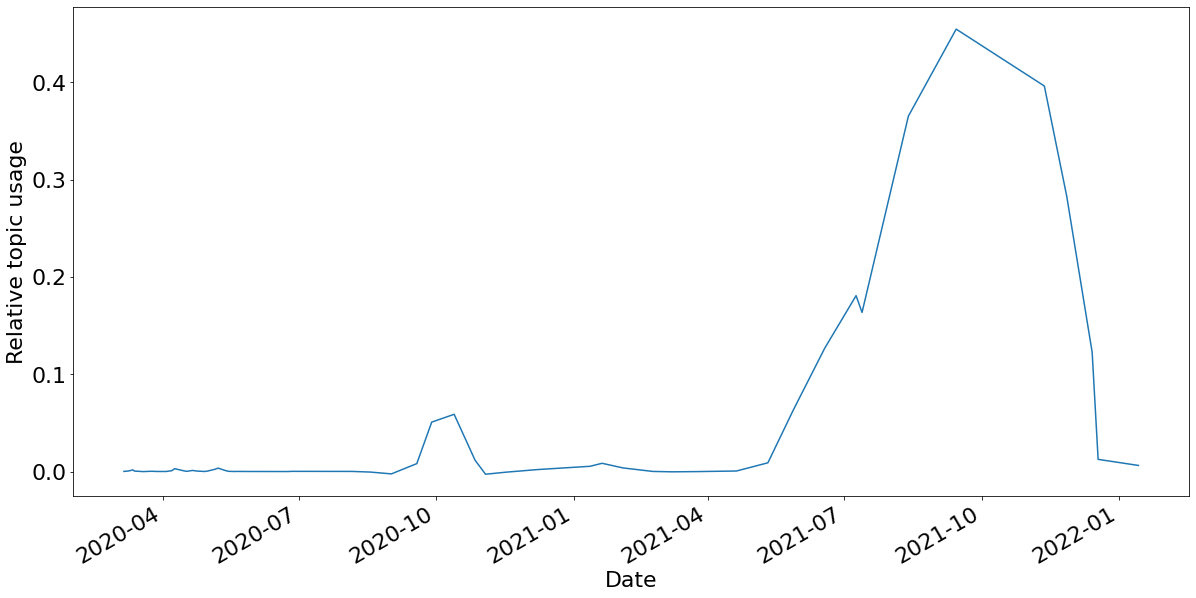

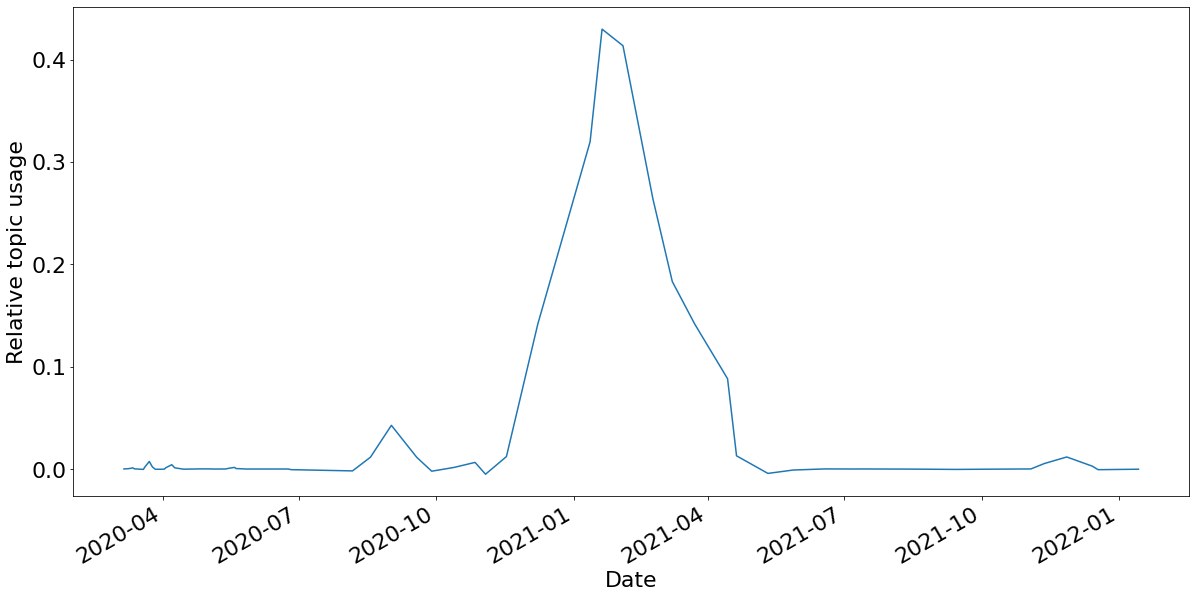

In [106]:
plot_topic(0)
plot_topic(1)